In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[-2]).unwrapped

discrete_actions = False

if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    
import gc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2
all_a = 0#.0001

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/3
        ex = ex**(1/(i+1))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,all_a,device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_loss_all = []
    dis_loss_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r = dis(real_batch).squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (nn.MSELoss()(dis_out_r,rank))
            dis_error_real.backward()
            dis_optimizer.step() 
            
            #generate children from population
            child = gen_children(population,device,gen,batch_size,a = all_a)
            
            #train generator
            dis_out_f = dis(child).squeeze(-1)
            gen_optimizer.zero_grad()
            gen_error = -torch.mean(dis_out_f)
            gen_error.backward()
            gen_optimizer.step() 
            
            #keep losses to draw graph   
            gen_loss_all.append(gen_error)
            dis_loss_all.append(dis_error_real)   
            
    return gen_loss_all, dis_loss_all


starting training
2904
Measured population fitness : 2s
population fitness : [-101.13143982  -44.15454993 -109.38032698 -121.06489478  -98.20440321
  -93.44723153 -107.55746466  -48.07763311  -96.88071029  -94.22338261]
mean fit : -91.41220369342723
Trained GAN : 0s
Evolved : 0s


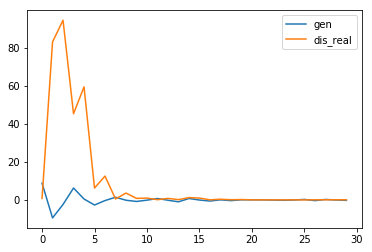

Generation 1  fitness : -44.154549933488035
#################################
Measured population fitness : 2s
population fitness : [-113.45154188  -95.11919928  -43.71711613 -121.32830981 -121.55948941
 -112.46700476  -99.77197801  -32.52693245  -95.75084422  -97.91046106]
mean fit : -93.36028770172624
Trained GAN : 1s
Evolved : 0s


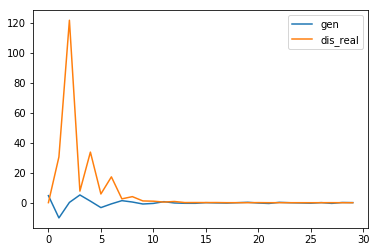

Generation 2  fitness : -32.52693245279746
#################################
Measured population fitness : 4s
population fitness : [-111.73554354  -31.8356165   -28.68498324  -98.55070267  -81.18004422
 -112.37937602 -107.20407078  -95.05925335  -46.23203638 -100.72404318]
mean fit : -81.35856698839231
Trained GAN : 0s
Evolved : 0s


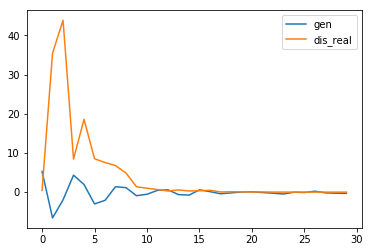

Generation 3  fitness : -28.68498324151799
#################################
Measured population fitness : 4s
population fitness : [ -28.69543052  -28.63329598 -113.89013865  -28.29007531  -49.37761146
  -93.79745752  -95.55127597  -96.39551359  -94.33766488 -109.54184063]
mean fit : -73.8510304501744
Trained GAN : 1s
Evolved : 0s


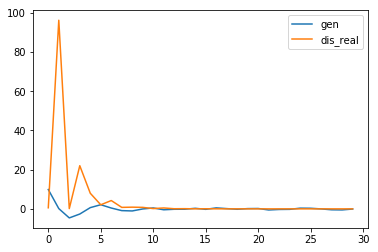

Generation 4  fitness : -28.29007530955701
#################################
Measured population fitness : 4s
population fitness : [ -21.32810494  -38.93041738  -92.91928894 -105.90762762 -103.51403531
  -97.73282021 -114.88303797  -40.25264604  -37.30351396  -91.77224119]
mean fit : -74.45437335549524
Trained GAN : 1s
Evolved : 0s


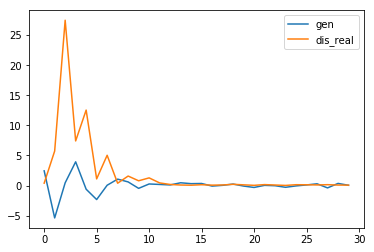

Generation 5  fitness : -21.32810494204943
#################################
Measured population fitness : 6s
population fitness : [ -40.18012321  -42.45847349  -98.69780204 -107.18560662 -102.44343393
  -67.11789643  -79.34437276  -57.60650698  -11.74613206 -107.55311052]
mean fit : -71.43334580589809
Trained GAN : 1s
Evolved : 0s


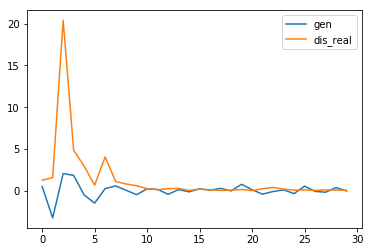

Generation 6  fitness : -11.746132059956874
#################################
Measured population fitness : 4s
population fitness : [ -33.71706498 -115.87755597  -14.20139261 -105.34388872  -12.11186889
  -95.10518839 -112.51597393 -100.53476979  -64.10946169 -115.88510653]
mean fit : -76.9402271516495
Trained GAN : 1s
Evolved : 0s


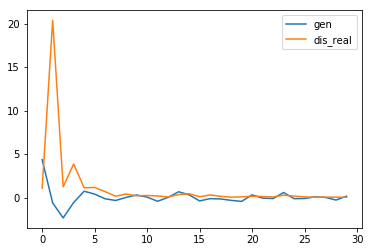

Generation 7  fitness : -12.111868892675245
#################################
Measured population fitness : 6s
population fitness : [  -7.43760711  -19.96493049  -42.51294146 -102.97097836  -57.82839181
  -70.3735402  -111.61798597 -112.79859888 -106.24735892  -39.07625024]
mean fit : -67.08285834202192
Trained GAN : 1s
Evolved : 0s


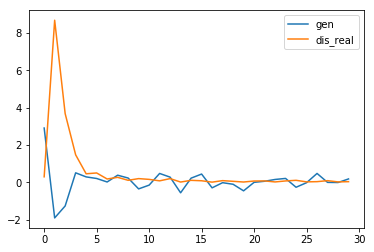

Generation 8  fitness : -7.437607105830086
#################################
Measured population fitness : 4s
population fitness : [ -22.31686573 -116.98569444  -18.06731691 -110.1300455  -118.42039643
  -30.47134933 -106.9709308   -95.55095333   -9.26420821 -120.58430314]
mean fit : -74.87620638163669
Trained GAN : 0s
Evolved : 0s


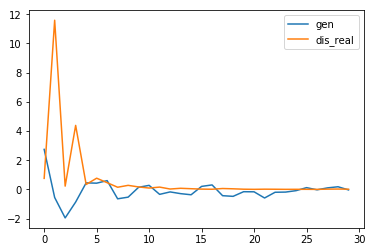

Generation 9  fitness : -9.264208208514969
#################################
Measured population fitness : 3s
population fitness : [-115.85655417  -20.60497216 -113.81782368 -106.67874273 -110.52790121
  -57.42190693 -111.88904892 -103.8104456  -112.45255443  -43.90501793]
mean fit : -89.69649677732178
Trained GAN : 0s
Evolved : 0s


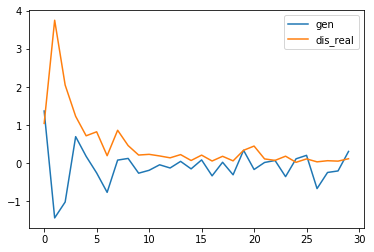

Generation 10  fitness : -20.604972164401175
#################################
Measured population fitness : 4s
population fitness : [ -72.56903228  -94.81189048 -113.48410793 -102.083664    -95.24279678
  -20.55972508   -8.17478244  -99.88349561  -80.77783954 -112.04303464]
mean fit : -79.96303687744985
Trained GAN : 1s
0.18087641500176088
Evolved : 0s


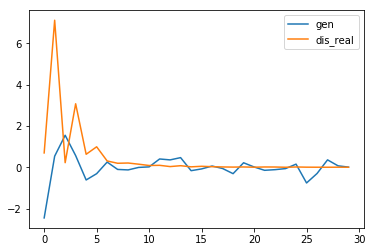

Generation 11  fitness : -8.174782443707702
#################################
Measured population fitness : 7s
population fitness : [ -19.50400393  -14.03227518   -8.20491502  -78.0319958   -19.00433863
  -45.99762352 -116.05069543  -70.37347395  -95.78013321 -105.06287948]
mean fit : -57.204233415182685
Trained GAN : 1s
Evolved : 0s


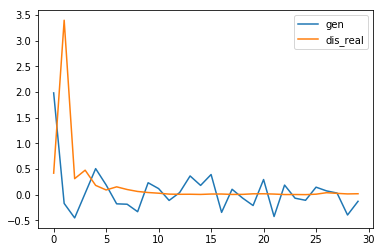

Generation 12  fitness : -8.204915017494946
#################################
Measured population fitness : 3s
population fitness : [ -18.2846091  -113.57395595 -106.27602594 -104.18522257 -114.62435991
  -36.93919294  -47.21932359 -112.25501974 -114.29916392  -95.92221375]
mean fit : -86.35790874148395
Trained GAN : 1s
Evolved : 0s


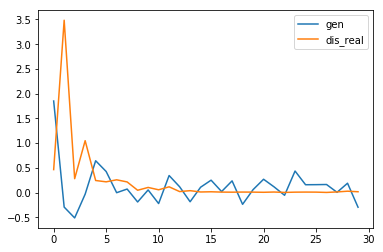

Generation 13  fitness : -18.28460909548158
#################################
Measured population fitness : 6s
population fitness : [-109.44273192 -113.24479838 -102.01932978  -47.52342688  -49.07569945
  -35.45700699 -102.25587362 -122.52782489  -31.12297442  -88.91504874]
mean fit : -80.15847150722855
Trained GAN : 1s
Evolved : 0s


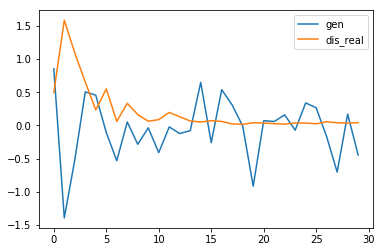

Generation 14  fitness : -31.12297442002907
#################################
Measured population fitness : 5s
population fitness : [-114.06807871  -31.34449414  -34.23468784 -106.14543079  -94.56101147
 -111.41766796 -110.39520955  -72.79627835  -35.99993986  -73.96182527]
mean fit : -78.49246239292248
Trained GAN : 1s
Evolved : 0s


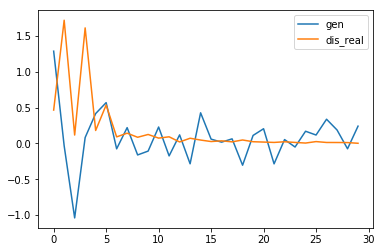

Generation 15  fitness : -31.344494135803064
#################################
Measured population fitness : 4s
population fitness : [-114.35604901  -62.04871197 -104.80313109 -102.28663083  -96.99424964
  -48.54616044 -106.57586728 -106.28917044  -38.21188969  -31.35259715]
mean fit : -81.14644575314844
Trained GAN : 1s
Evolved : 0s


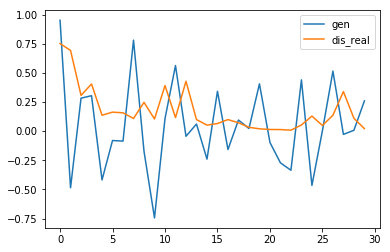

Generation 16  fitness : -31.352597152781946
#################################
Measured population fitness : 6s
population fitness : [ -32.32942629  -45.33188741 -114.78666391  -99.81918949 -114.92385546
  -24.74661207 -126.36600817  -55.75047358  -96.76418726  -46.79653101]
mean fit : -75.76148346327821
Trained GAN : 1s
Evolved : 0s


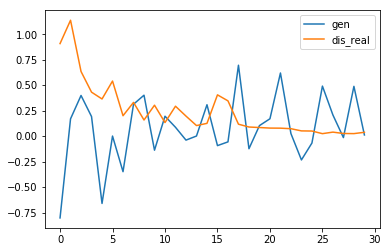

Generation 17  fitness : -24.746612067481347
#################################
Measured population fitness : 4s
population fitness : [-112.48138523 -100.83590958 -117.51976374 -104.4393981  -128.99275629
 -108.23637872  -73.51407714  -24.54436323 -100.43641332 -115.24957471]
mean fit : -98.62500200467342
Trained GAN : 1s
Evolved : 0s


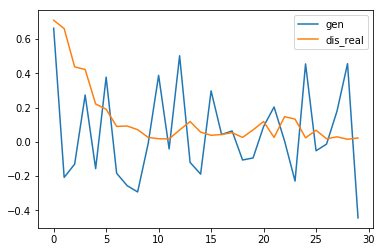

Generation 18  fitness : -24.544363232541205
#################################
Measured population fitness : 6s
population fitness : [-114.17538334  -77.9016317   -52.17132059  -71.48838891  -40.70219791
  -24.33573573  -26.82732082 -125.66057207 -107.85147804 -112.31232596]
mean fit : -75.34263550793385
Trained GAN : 0s
Evolved : 0s


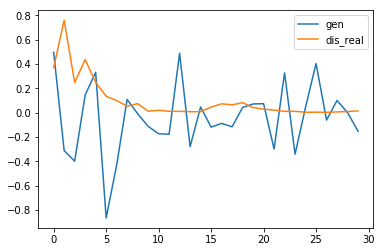

Generation 19  fitness : -24.33573573440873
#################################
Measured population fitness : 6s
population fitness : [ -24.41058612 -123.44465604  -41.37917963 -114.70235419  -85.57090616
 -105.51590301 -120.87058474  -27.76025802 -126.54814659  -94.29504691]
mean fit : -86.44976214006894
Trained GAN : 1s
Evolved : 0s


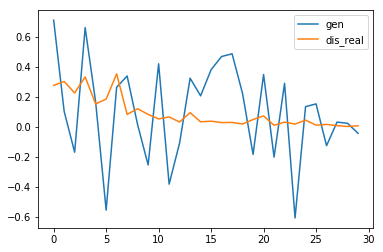

Generation 20  fitness : -24.410586123884272
#################################
Measured population fitness : 4s
population fitness : [ -57.18427697 -111.23308796  -25.26116751  -75.01247563 -112.10400429
 -100.05824498  -96.45392525 -104.66455843 -120.36719984  -57.62694372]
mean fit : -85.9965884599827
Trained GAN : 1s
0.16358138751944612
Evolved : 0s


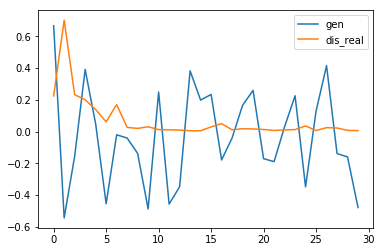

Generation 21  fitness : -25.26116751000653
#################################
Measured population fitness : 5s
population fitness : [-122.86049215 -103.59550148  -65.41484743 -132.71706399 -106.70032465
  -51.07399136 -100.04485818  -51.47444597  -47.1554791   -32.14178092]
mean fit : -81.31787852349781
Trained GAN : 1s
Evolved : 0s


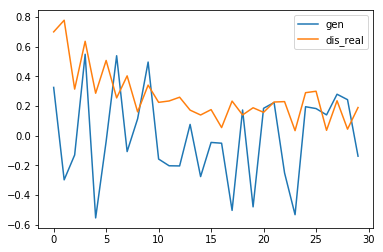

Generation 22  fitness : -32.141780915131825
#################################
Measured population fitness : 6s
population fitness : [ -58.40810543  -56.31252696 -104.68931648 -122.87474187  -59.45203874
  -95.806582    -98.96597988  -40.07132945  -29.32356991 -108.01424596]
mean fit : -77.39184366657562
Trained GAN : 1s
Evolved : 0s


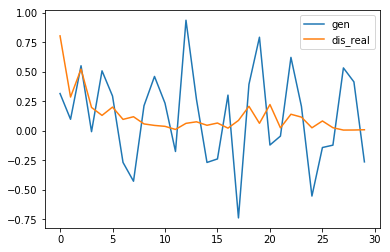

Generation 23  fitness : -29.323569907881282
#################################
Measured population fitness : 5s
population fitness : [ -80.29570949  -83.23407729 -114.06144068  -97.72207538  -31.91354943
 -107.02263679  -69.60713372  -46.23775991  -42.07864114  -99.12339341]
mean fit : -77.12964172359685
Trained GAN : 1s
Evolved : 0s


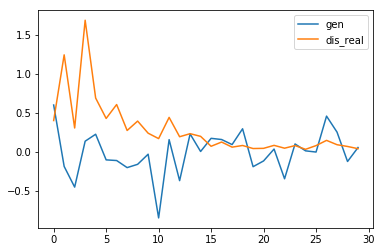

Generation 24  fitness : -31.913549427922977
#################################
Measured population fitness : 4s
population fitness : [ -96.75987827 -111.27675941  -74.78128837  -78.29018347 -115.64251194
 -109.38370533 -112.46656843 -112.06502545 -108.22024935  -96.01161087]
mean fit : -101.48977809023405
Trained GAN : 1s
Evolved : 0s


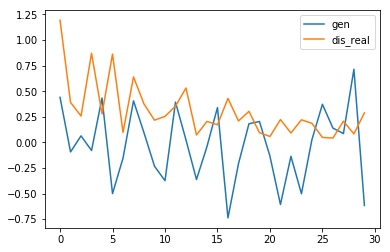

Generation 25  fitness : -74.78128837303443
#################################
Measured population fitness : 6s
population fitness : [ -58.61025146 -128.3257546  -103.66582956 -100.44246644  -97.95001047
 -113.61799797  -79.38365832  -42.00323529 -114.00222226  -99.44658336]
mean fit : -93.74480097400019
Trained GAN : 1s
Evolved : 0s


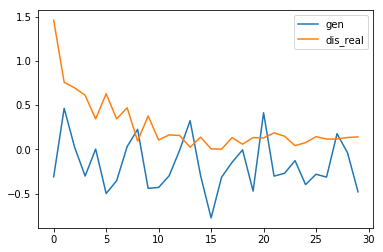

Generation 26  fitness : -42.00323528576788
#################################
Measured population fitness : 4s
population fitness : [-111.51206742  -98.7035076   -68.39562567  -35.01855184  -65.75922227
  -98.61993637 -107.51343257 -107.7834055   -68.36074962 -111.12039046]
mean fit : -87.27868893162996
Trained GAN : 1s
Evolved : 0s


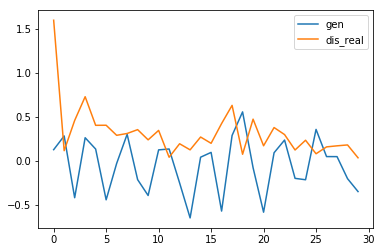

Generation 27  fitness : -35.01855183926779
#################################
Measured population fitness : 5s
population fitness : [ -24.93073273 -112.91881962 -100.3990459   -97.23550695 -104.77133046
 -108.32310248  -87.1621472  -132.63178215  -96.66631181 -111.56975811]
mean fit : -97.66085374141355
Trained GAN : 1s
Evolved : 0s


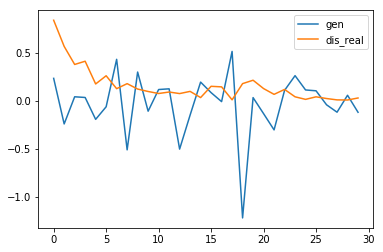

Generation 28  fitness : -24.930732733025494
#################################
Measured population fitness : 2s
population fitness : [ -90.23877905 -109.00338399  -99.17117206 -116.91971696 -106.65841355
 -116.41380762 -107.14649908 -172.16628792  -97.10537124 -111.46093987]
mean fit : -112.62843713313562
Trained GAN : 1s
Evolved : 0s


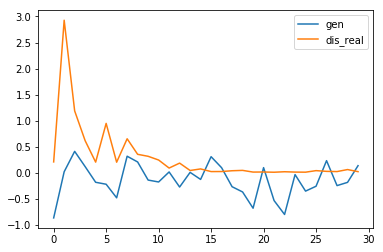

Generation 29  fitness : -90.23877904668544
#################################
Measured population fitness : 2s
population fitness : [-106.8599274   -99.80083952 -118.80781212  -97.87798388 -107.23139555
 -125.13887935  -80.43210107 -124.97714013 -160.84212093 -108.87019153]
mean fit : -113.08383914814696
Trained GAN : 1s
Evolved : 0s


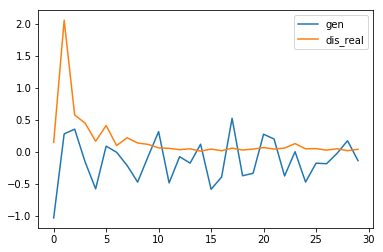

Generation 30  fitness : -80.43210106644338
#################################
Measured population fitness : 5s
population fitness : [ -43.66321084 -114.24570189 -138.29425247 -117.26225582 -111.00478382
 -110.8593004  -149.92719551 -100.65208859 -146.6440999  -175.31769596]
mean fit : -120.78705851942172
Trained GAN : 0s
0.147940074677656
Evolved : 0s


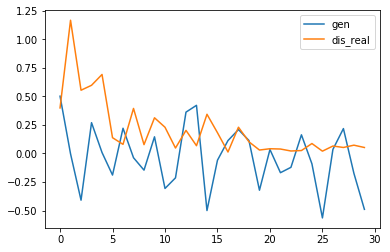

Generation 31  fitness : -43.66321083588332
#################################
Measured population fitness : 3s
population fitness : [-139.05160504 -115.05453303 -118.14289523  -40.98139431 -139.08374321
  -40.99638053 -100.98831274 -107.11083385  -35.88393565 -100.69219255]
mean fit : -93.7985826128598
Trained GAN : 1s
Evolved : 0s


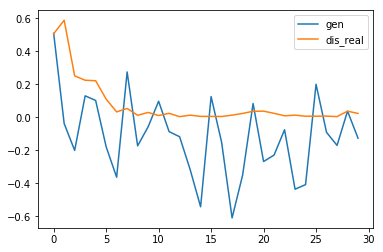

Generation 32  fitness : -35.88393565248568
#################################
Measured population fitness : 5s
population fitness : [-108.4257656   -29.66121474 -118.29649758 -117.3984163  -112.30177959
 -115.02542141  -82.90990568  -61.3111499  -105.35086057 -101.45496811]
mean fit : -95.21359794847582
Trained GAN : 1s
Evolved : 0s


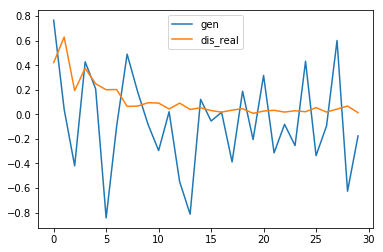

Generation 33  fitness : -29.661214738946995
#################################
Measured population fitness : 4s
population fitness : [ -30.63865936 -100.08497919 -109.92210878 -120.97860242  -64.70635552
 -119.68536965 -124.69721879 -129.00077704 -107.84980904  -59.49463336]
mean fit : -96.70585131346053
Trained GAN : 1s
Evolved : 0s


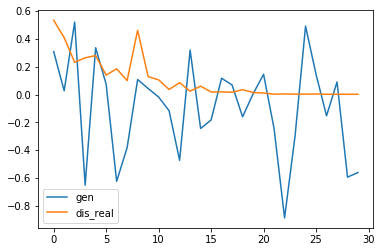

Generation 34  fitness : -30.638659355387414
#################################
Measured population fitness : 7s
population fitness : [-106.88391905 -112.75584845  -99.80561796  -69.86495589  -60.26899737
  -31.14254636  -64.28788106  -47.68989771 -157.16394602  -28.31186291]
mean fit : -77.81754727752475
Trained GAN : 1s
Evolved : 0s


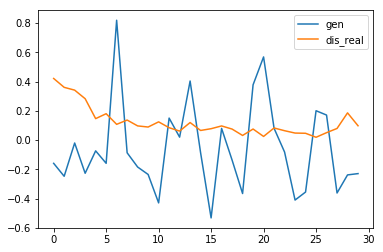

Generation 35  fitness : -28.311862913763186
#################################
Measured population fitness : 4s
population fitness : [ -62.7279714   -43.83225327 -126.80221936 -114.25805971  -70.40157454
 -104.88242034 -101.18904357  -87.3306531  -102.68887349 -119.59655738]
mean fit : -93.37096261560767
Trained GAN : 1s
Evolved : 0s


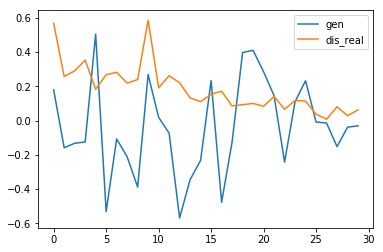

Generation 36  fitness : -43.832253266452575
#################################
Measured population fitness : 5s
population fitness : [-125.67634738  -99.02593434  -61.8203149  -106.17226496  -78.09717611
  -49.43110199 -101.16598107  -96.60673146  -56.9457869   -97.35366434]
mean fit : -87.22953034428608
Trained GAN : 1s
Evolved : 0s


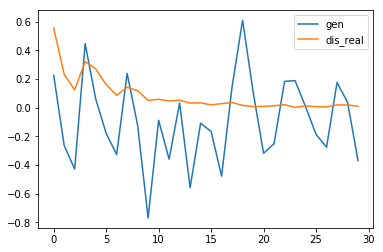

Generation 37  fitness : -49.43110199113505
#################################
Measured population fitness : 7s
population fitness : [-126.69359116 -126.16025432 -123.29104283 -117.81936898  -19.81841534
  -71.69110299  -72.15466047  -81.02288519  -41.41909002  -61.95714144]
mean fit : -84.20275527423405
Trained GAN : 1s
Evolved : 0s


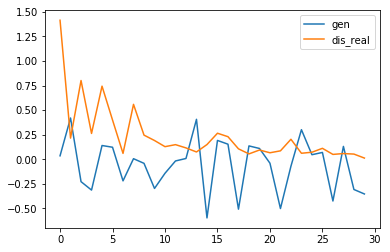

Generation 38  fitness : -19.818415342763004
#################################
Measured population fitness : 7s
population fitness : [ -78.52176029  -71.47873719 -126.23688331 -112.82040508  -33.6429597
  -46.341388    -38.90466034  -19.71005513  -96.82108621 -136.08422148]
mean fit : -76.05621567213005
Trained GAN : 1s
Evolved : 0s


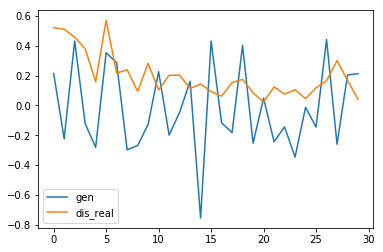

Generation 39  fitness : -19.710055127808833
#################################
Measured population fitness : 7s
population fitness : [ -26.29494416  -38.93731689  -74.77443882  -58.44492511  -79.8039185
 -101.75151759  -65.00648717 -116.79247461  -47.92342924  -20.33048523]
mean fit : -63.005993730263526
Trained GAN : 1s
Evolved : 0s


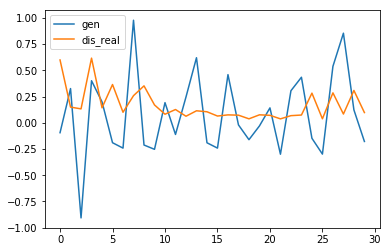

Generation 40  fitness : -20.330485229100933
#################################
Measured population fitness : 8s
population fitness : [ -90.84464965  -19.78662514 -101.69053383 -119.00468161  -35.90798339
  -36.56649599  -47.95105952 -126.12471347  -33.58134091 -102.44718826]
mean fit : -71.39052717759706
Trained GAN : 1s
0.13379435171393603
Evolved : 0s


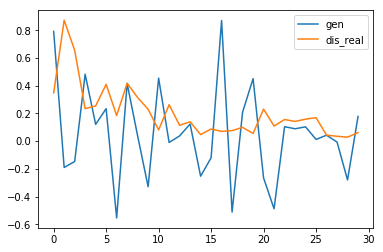

Generation 41  fitness : -19.786625142784388
#################################
Measured population fitness : 8s
population fitness : [ -37.03460324  -66.36428767  -64.19981768  -90.06422616 -129.53486723
  -51.44791237 -107.21440646  -88.95655948  -47.64034906  -48.27150523]
mean fit : -73.07285345848696
Trained GAN : 1s
Evolved : 0s


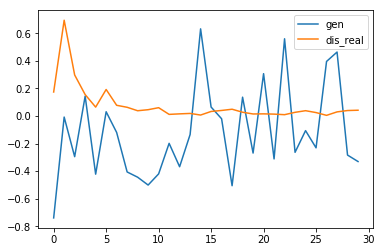

Generation 42  fitness : -37.03460323920747
#################################
Measured population fitness : 9s
population fitness : [ -25.15270371  -85.40013399  -59.53363669  -38.49588082  -59.3073119
  -74.06658637  -63.83884681 -131.8871805   -51.19424151  -87.0719795 ]
mean fit : -67.59485018096849
Trained GAN : 1s
Evolved : 0s


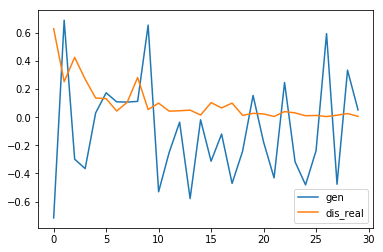

Generation 43  fitness : -25.152703711085135
#################################
Measured population fitness : 7s
population fitness : [ -85.85388659  -69.93019062  -97.12671433  -52.58363594 -130.0185873
  -42.0786738  -102.96049418  -44.92405361  -25.26934931  -77.13343731]
mean fit : -72.78790229899415
Trained GAN : 1s
Evolved : 0s


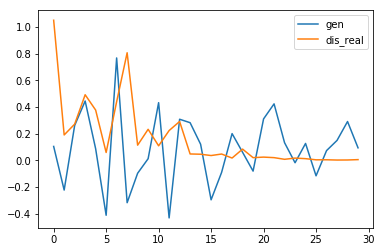

Generation 44  fitness : -25.269349308572256
#################################
Measured population fitness : 9s
population fitness : [ -40.99290342  -79.03917889 -149.3540752   -53.97828736  -99.15334287
  -62.50595116 -106.36522295  -94.83681695  -54.07988067  -48.37881468]
mean fit : -78.86844741544412
Trained GAN : 1s
Evolved : 0s


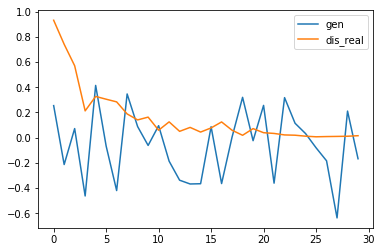

Generation 45  fitness : -40.99290341910677
#################################
Measured population fitness : 8s
population fitness : [ -47.0918021   -97.00685711  -71.861042    -47.25424022  -90.57860211
  -33.62543255  -59.04440031 -106.68078905  -32.42308416 -131.6908453 ]
mean fit : -71.72570949158842
Trained GAN : 1s
Evolved : 0s


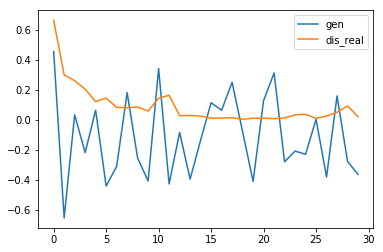

Generation 46  fitness : -32.42308416451626
#################################
Measured population fitness : 8s
population fitness : [ -41.47632332  -36.89141244  -62.47471037  -48.73451849  -54.10893543
  -70.79372661 -121.48473646  -91.66892753  -94.60066135  -76.85252667]
mean fit : -69.90864786735041
Trained GAN : 1s
Evolved : 0s


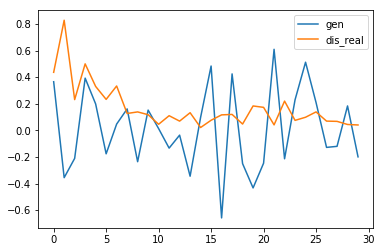

Generation 47  fitness : -36.8914124415754
#################################
Measured population fitness : 8s
population fitness : [ -47.67288551  -82.488498    -83.32987807  -36.72918148 -113.60150088
  -49.87549232  -93.64197446 -124.20357831 -112.25306142  -62.46606778]
mean fit : -80.62621182434648
Trained GAN : 1s
Evolved : 0s


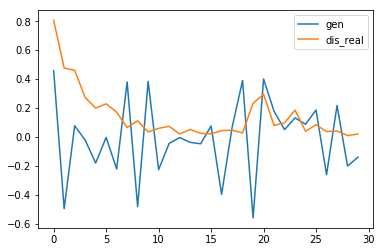

Generation 48  fitness : -36.72918148462723
#################################
Measured population fitness : 7s
population fitness : [ -83.05788737  -79.90653064 -130.67764306  -45.147444    -42.31542073
  -36.19758882  -49.33999911  -54.63671862  -59.93505164  -96.74531292]
mean fit : -67.79595969053011
Trained GAN : 0s
Evolved : 0s


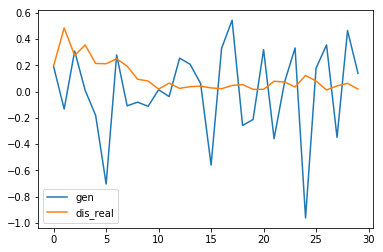

Generation 49  fitness : -36.197588822779
#################################
Measured population fitness : 8s
population fitness : [ -85.78684347  -80.01710971  -30.11324581  -50.40877353  -48.4961216
  -60.18786772  -98.98163917 -119.11633235  -66.19765829  -76.26468252]
mean fit : -71.55702741818791
Trained GAN : 1s
Evolved : 0s


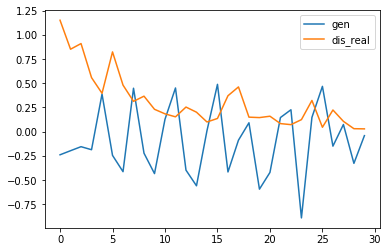

Generation 50  fitness : -30.113245809196137
#################################
Measured population fitness : 7s
population fitness : [-124.93149465  -19.13529618  -84.32738302  -74.82305035  -31.57239895
 -107.11635476  -57.6520352  -109.98368706  -75.27256031  -72.16172652]
mean fit : -75.69759869994672
Trained GAN : 0s
0.12100121342750728
Evolved : 0s


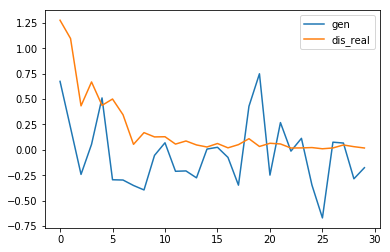

Generation 51  fitness : -19.13529618131681
#################################
Measured population fitness : 8s
population fitness : [-102.41305233  -58.52709488 -133.00551619  -90.37276488  -17.65874193
  -65.5128233   -56.68911258  -76.65976935  -73.05810609  -63.73922155]
mean fit : -73.76362030755715
Trained GAN : 1s
Evolved : 0s


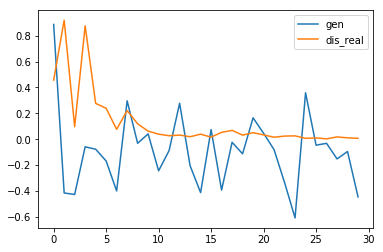

Generation 52  fitness : -17.658741928048695
#################################
Measured population fitness : 8s
population fitness : [ -18.41896758  -55.0178303   -35.38913081 -107.35798702  -40.58263629
  -28.71541367 -108.2995904  -129.64841602  -65.8483548   -74.05156466]
mean fit : -66.33298915607388
Trained GAN : 1s
Evolved : 0s


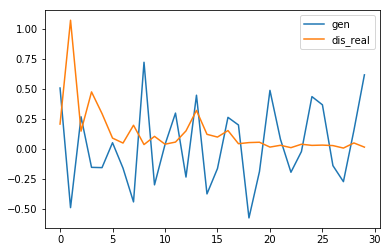

Generation 53  fitness : -18.418967579441745
#################################
Measured population fitness : 9s
population fitness : [ -56.73437886 -106.30004958  -53.66658719 -108.05234008  -99.72860486
  -18.24843123  -71.66095569  -64.00459269  -47.58352082  -29.78914265]
mean fit : -65.57686036461692
Trained GAN : 1s
Evolved : 0s


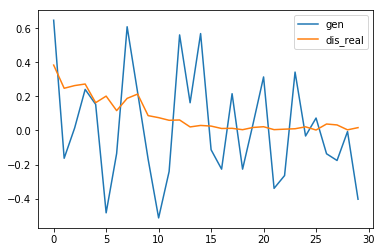

Generation 54  fitness : -18.248431232448613
#################################
Measured population fitness : 9s
population fitness : [-62.35540973 -93.09428771 -18.02915474 -64.06451878 -48.82927277
 -57.21875169 -48.68534719 -89.31499363 -77.73853794 -73.27824546]
mean fit : -63.26085196427878
Trained GAN : 1s
Evolved : 0s


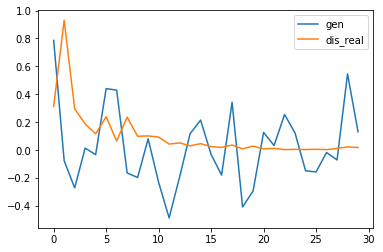

Generation 55  fitness : -18.029154739794656
#################################
Measured population fitness : 9s
population fitness : [-92.06132268 -76.77782321 -81.77768789 -67.80664402 -57.96913193
 -35.60258297 -64.81391108 -34.97488137 -64.1927277  -64.80255861]
mean fit : -64.07792714721997
Trained GAN : 1s
Evolved : 0s


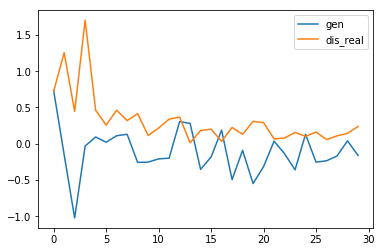

Generation 56  fitness : -34.9748813724146
#################################
Measured population fitness : 8s
population fitness : [-108.32782328 -107.82043853  -64.54751457  -42.44774947  -55.92115367
  -60.78489923  -44.78777623 -102.75196541  -46.26745994  -62.65504537]
mean fit : -69.63118256894326
Trained GAN : 1s
Evolved : 0s


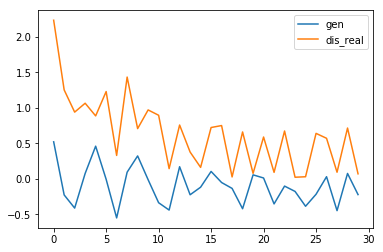

Generation 57  fitness : -42.447749468646315
#################################
Measured population fitness : 10s
population fitness : [-54.80682382 -78.84181296 -78.31809344 -32.66075409 -86.41561778
 -37.41922785 -83.65878762 -83.96768009 -43.02025742 -47.00368068]
mean fit : -62.6112735742603
Trained GAN : 1s
Evolved : 0s


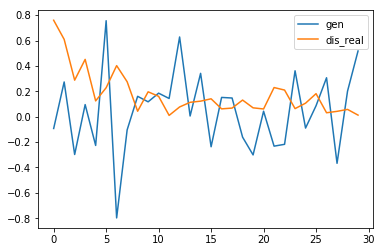

Generation 58  fitness : -32.66075409021288
#################################
Measured population fitness : 7s
population fitness : [ -91.13443796 -105.16067473 -134.85778865  -63.01520329  -87.92973395
  -34.71224545  -66.82744474 -112.63129655  -44.01199525 -116.76107995]
mean fit : -85.70419005418532
Trained GAN : 1s
Evolved : 0s


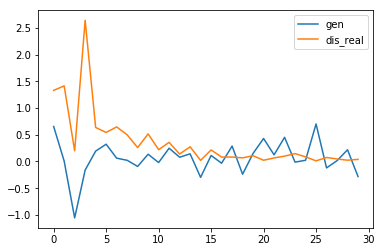

Generation 59  fitness : -34.71224545355234
#################################
Measured population fitness : 6s
population fitness : [ -99.65038789 -102.62527143  -63.6295277   -76.85915157  -73.46186025
 -121.09910025 -116.73729994  -70.94641948  -43.35803976  -60.9620827 ]
mean fit : -82.93291409718046
Trained GAN : 1s
Evolved : 0s


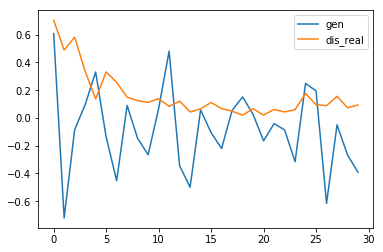

Generation 60  fitness : -43.35803976265284
#################################
Measured population fitness : 9s
population fitness : [ -43.10589166  -89.16833322  -73.92929789  -68.12066365  -45.10571358
  -49.34064347  -81.62439709  -62.57102139  -78.1904552  -107.2689515 ]
mean fit : -69.84253686521814
Trained GAN : 1s
0.10943132847815225
Evolved : 0s


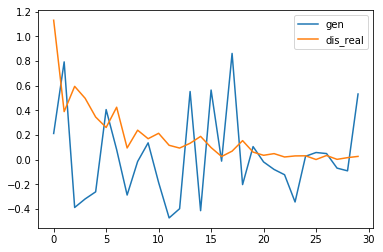

Generation 61  fitness : -43.105891655074366
#################################
Measured population fitness : 8s
population fitness : [-121.29701451  -55.68149879  -69.34058574  -89.73073111  -59.76684449
  -74.08805009  -65.06856207 -121.23920902  -46.86260415  -74.0439002 ]
mean fit : -77.71190001584829
Trained GAN : 1s
Evolved : 0s


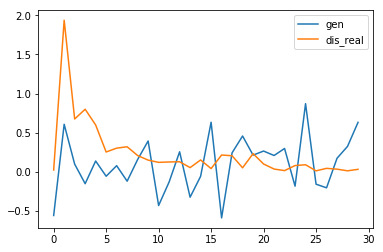

Generation 62  fitness : -46.86260415065193
#################################
Measured population fitness : 8s
population fitness : [ -84.7551612   -60.17505992  -83.89487199  -88.2881082   -97.4475597
 -109.50109481  -52.72627255  -48.92866706  -94.73395992  -87.17342759]
mean fit : -80.76241829400962
Trained GAN : 1s
Evolved : 0s


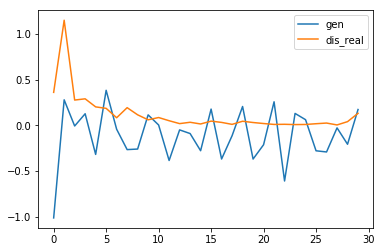

Generation 63  fitness : -48.92866705872287
#################################
Measured population fitness : 6s
population fitness : [-113.55395728  -79.02411145 -102.27018333  -73.59460807  -36.26029481
  -69.34376079  -49.79745228 -130.95678885  -86.36914195  -97.06671805]
mean fit : -83.82370168576827
Trained GAN : 1s
Evolved : 0s


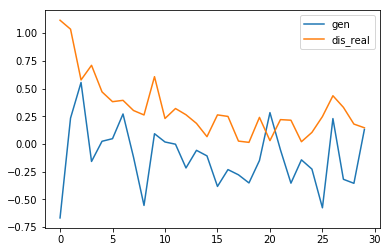

Generation 64  fitness : -36.26029480903456
#################################
Measured population fitness : 9s
population fitness : [-106.59614596  -44.88003272  -89.14606474  -96.51616703  -69.89361497
  -73.59231883  -37.50103897  -56.23473613  -53.19463349 -128.66146084]
mean fit : -75.62162136820312
Trained GAN : 1s
Evolved : 0s


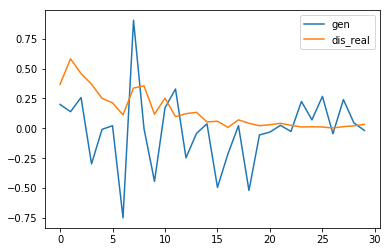

Generation 65  fitness : -37.50103897203637
#################################
Measured population fitness : 6s
population fitness : [ -64.81954273 -107.69004074  -91.52038939  -53.33525772 -105.0070527
  -20.69641493 -104.36255079  -52.8624667   -65.31880776 -123.73143512]
mean fit : -78.93439585798191
Trained GAN : 1s
Evolved : 0s


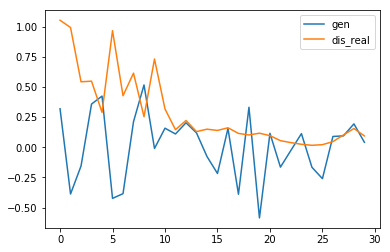

Generation 66  fitness : -20.69641493141159
#################################
Measured population fitness : 7s
population fitness : [ -52.25619329 -105.63317128  -75.50673009 -123.94129389  -87.16553836
 -102.44050302  -59.93857865  -96.448666   -104.82722513  -64.22649603]
mean fit : -87.23843957469393
Trained GAN : 1s
Evolved : 0s


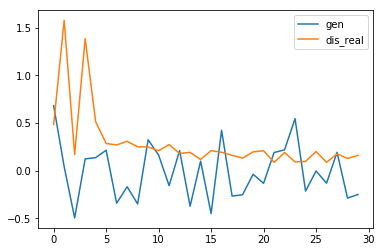

Generation 67  fitness : -52.25619329193671
#################################
Measured population fitness : 5s
population fitness : [ -56.80798644  -60.23817755 -104.19813057  -51.19850897 -105.804281
  -97.16181463  -36.54084414 -101.05301822 -100.029508   -102.72076334]
mean fit : -81.57530328567569
Trained GAN : 1s
Evolved : 0s


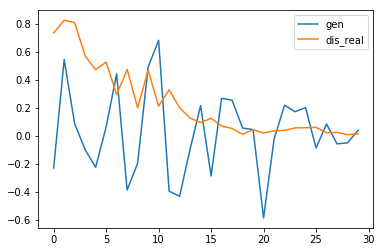

Generation 68  fitness : -36.54084413537701
#################################
Measured population fitness : 6s
population fitness : [ -67.51771066  -76.2177226   -99.82863012  -43.62930124 -121.95828753
 -102.1410221  -129.40141896  -52.32166055  -50.83246321  -62.70349946]
mean fit : -80.65517164380103
Trained GAN : 1s
Evolved : 0s


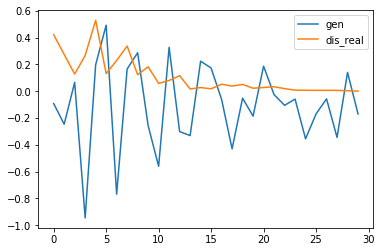

Generation 69  fitness : -43.62930123778011
#################################
Measured population fitness : 9s
population fitness : [ -90.81847607  -47.21984727  -94.6620705   -61.48191734  -80.16090728
 -113.23366985  -78.02242158  -92.02957115  -43.97446699  -85.96026491]
mean fit : -78.75636129270049
Trained GAN : 1s
Evolved : 0s


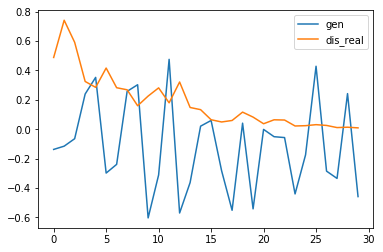

Generation 70  fitness : -43.974466989458335
#################################
Measured population fitness : 8s
population fitness : [ -82.61844724  -42.21654383  -69.46222819  -49.33301467  -63.60158825
  -66.46648948  -46.24368525 -100.61460228  -89.9643921   -58.02539882]
mean fit : -66.8546390097504
Trained GAN : 1s
0.09896773192004141
Evolved : 0s


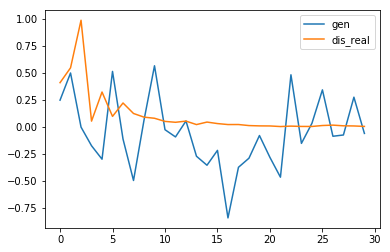

Generation 71  fitness : -42.21654382543758
#################################
Measured population fitness : 7s
population fitness : [-153.54315029 -104.85845975  -93.51601588  -89.00480621  -60.74511973
  -67.9142184  -111.606291    -69.17366232 -131.54916964  -66.0789229 ]
mean fit : -94.79898161211582
Trained GAN : 1s
Evolved : 0s


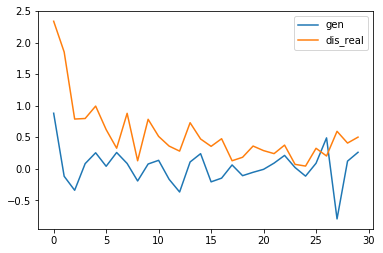

Generation 72  fitness : -60.745119732628865
#################################
Measured population fitness : 8s
population fitness : [-118.36571397 -100.24978129  -51.57159526  -34.62553739 -113.74620477
  -39.69150748  -98.52850253  -61.48758293  -58.61414273  -67.0833811 ]
mean fit : -74.39639494480234
Trained GAN : 1s
Evolved : 0s


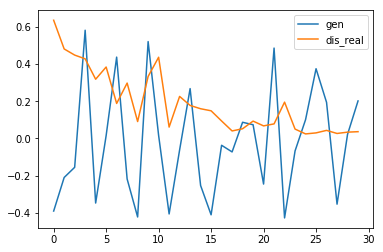

Generation 73  fitness : -34.62553738734186
#################################
Measured population fitness : 6s
population fitness : [ -83.96114823 -119.256151    -88.89861341 -119.15700678 -121.32392695
 -118.96972389  -42.19972828 -123.73941426 -124.44676439  -98.86432555]
mean fit : -104.08168027299371
Trained GAN : 1s
Evolved : 0s


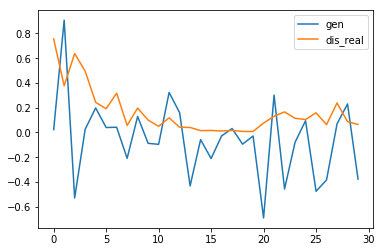

Generation 74  fitness : -42.199728278569395
#################################
Measured population fitness : 8s
population fitness : [ -99.68562326  -48.65330303  -65.94616706 -104.97460594 -117.40006559
  -43.08375346  -93.81703914 -146.39507655  -80.20528865  -98.05771156]
mean fit : -89.82186342419205
Trained GAN : 1s
Evolved : 0s


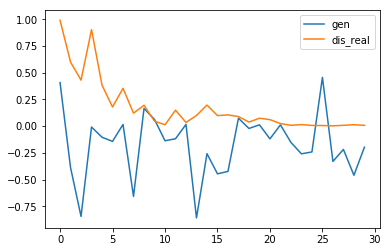

Generation 75  fitness : -43.083753457349104
#################################
Measured population fitness : 7s
population fitness : [ -43.19480443 -115.63601607  -74.61834276 -143.91861395 -101.72451914
  -99.25463913  -76.38377255  -63.73207699  -71.72942763  -74.71019435]
mean fit : -86.49024069999336
Trained GAN : 1s
Evolved : 0s


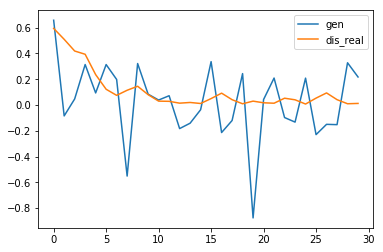

Generation 76  fitness : -43.19480443275974
#################################
Measured population fitness : 8s
population fitness : [ -76.60458735  -42.74531213  -43.0422219  -115.27874671  -77.8193994
  -98.88149217 -133.60040677  -85.18969349  -64.28699483 -118.51934436]
mean fit : -85.59681990989013
Trained GAN : 1s
Evolved : 0s


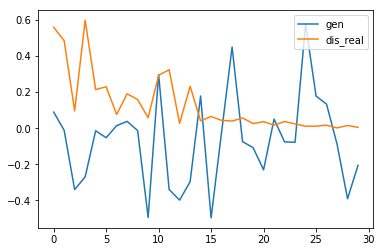

Generation 77  fitness : -42.745312127354644
#################################
Measured population fitness : 8s
population fitness : [ -71.88025296  -63.36917522  -43.84551917 -119.11371578  -90.52515769
  -98.67727454 -136.7310592  -133.55427871  -35.67996158 -119.82450844]
mean fit : -91.32009032910769
Trained GAN : 1s
Evolved : 0s


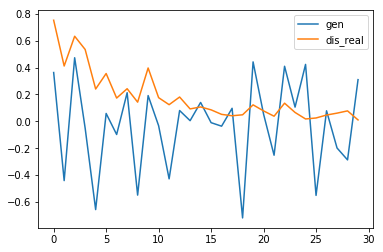

Generation 78  fitness : -35.679961575741586
#################################
Measured population fitness : 6s
population fitness : [ -57.17917572  -70.99002206 -123.28790423  -83.47428887 -127.64987022
  -84.88565756  -69.35763439 -119.36313526 -100.35590182  -43.20590615]
mean fit : -87.97494962851549
Trained GAN : 1s
Evolved : 0s


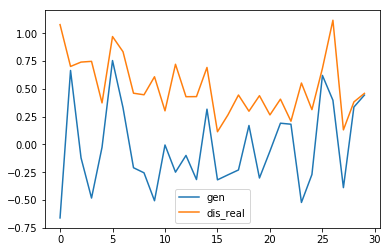

Generation 79  fitness : -43.20590614803786
#################################
Measured population fitness : 8s
population fitness : [ -72.97183984  -42.24904738 -100.98707832  -92.32051909  -98.93254554
  -62.45509111 -119.08700295  -96.39981347  -92.87669669  -46.46153225]
mean fit : -82.47411666522542
Trained GAN : 1s
Evolved : 0s


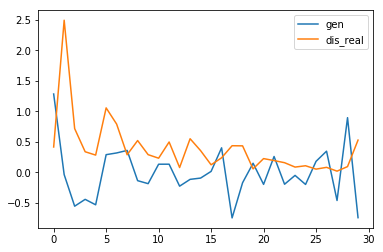

Generation 80  fitness : -42.24904738460694
#################################
Measured population fitness : 10s
population fitness : [ -80.12773457  -50.98667269  -54.73507894  -41.58561738 -100.52533747
  -90.55211634  -43.68415415  -58.26252069  -64.13396311  -18.96540053]
mean fit : -60.35585958807911
Trained GAN : 1s
0.08950464275276215
Evolved : 0s


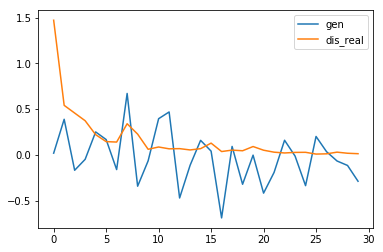

Generation 81  fitness : -18.965400533150945
#################################
Measured population fitness : 8s
population fitness : [-101.67217454 -122.60996152  -64.62725088  -61.24688343 -159.80716696
 -131.07856954  -54.88521492  -60.14363305  -74.14135334  -25.01543134]
mean fit : -85.52276395252034
Trained GAN : 1s
Evolved : 0s


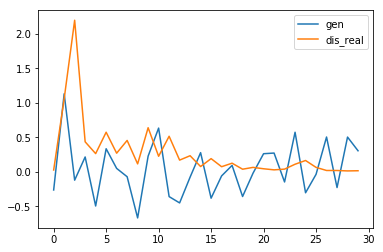

Generation 82  fitness : -25.015431341746755
#################################
Measured population fitness : 8s
population fitness : [-104.08965392  -50.64046729 -124.03205344  -78.65948753  -43.4530314
 -109.36261479  -84.93054859 -150.48239979  -59.03350585 -117.47925884]
mean fit : -92.21630214396595
Trained GAN : 1s
Evolved : 0s


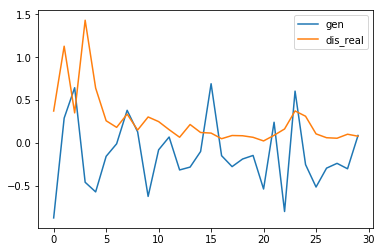

Generation 83  fitness : -43.453031399734556
#################################
Measured population fitness : 9s
population fitness : [ -19.01320719 -120.27809624  -90.50734217  -42.99949762  -82.6266264
  -32.97110159 -111.47851535  -25.6187758  -136.48497893 -113.00913919]
mean fit : -77.49872804869106
Trained GAN : 1s
Evolved : 0s


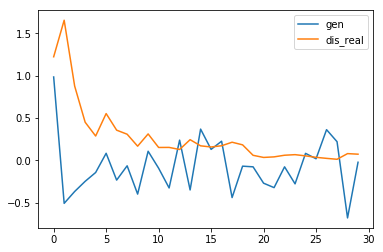

Generation 84  fitness : -19.013207194350983
#################################
Measured population fitness : 9s
population fitness : [ -83.14155139  -89.57822757  -92.39280267  -84.69609679  -93.15072405
 -123.25925805  -71.27510722  -90.84873285  -91.41494598  -86.61028813]
mean fit : -90.63677346992633
Trained GAN : 1s
Evolved : 0s


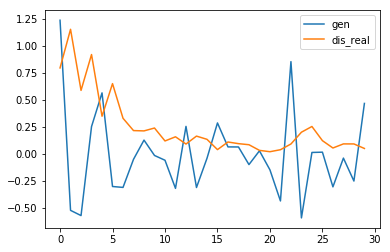

Generation 85  fitness : -71.27510722255428
#################################
Measured population fitness : 8s
population fitness : [ -94.54794536  -97.48070908  -85.75008419 -100.97163917  -50.35747407
 -109.91396355 -102.70282651 -104.4031023  -111.6951151   -70.86979677]
mean fit : -92.86926560870282
Trained GAN : 1s
Evolved : 0s


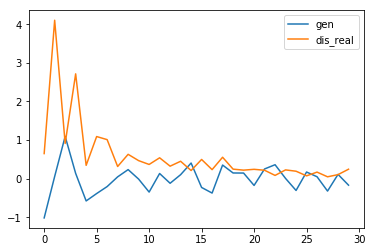

Generation 86  fitness : -50.35747406782772
#################################
Measured population fitness : 10s
population fitness : [ -89.92691451 -121.44809485  -49.20302219 -127.62341798 -119.75531434
  -67.75398237 -115.47140951  -57.76204992  -53.56207842  -52.37843303]
mean fit : -85.48847171301688
Trained GAN : 1s
Evolved : 0s


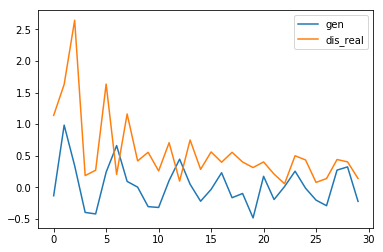

Generation 87  fitness : -49.203022189236314
#################################
Measured population fitness : 11s
population fitness : [ -60.35246218  -81.53500567  -50.56058578  -47.89254016  -98.01968669
  -81.4447671  -159.65557743  -49.95134891  -70.47487665 -105.17961138]
mean fit : -80.50664619468162
Trained GAN : 1s
Evolved : 0s


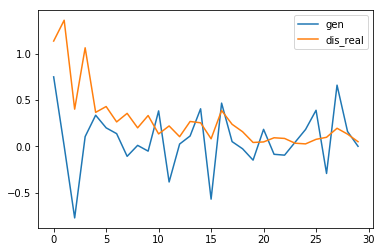

Generation 88  fitness : -47.89254016345863
#################################
Measured population fitness : 8s
population fitness : [ -47.95871787  -71.63316667 -121.3416137   -48.09351583  -73.12859342
 -134.07562173  -50.60527602 -104.52542911  -62.48162328 -138.47926008]
mean fit : -85.23228177082919
Trained GAN : 1s
Evolved : 0s


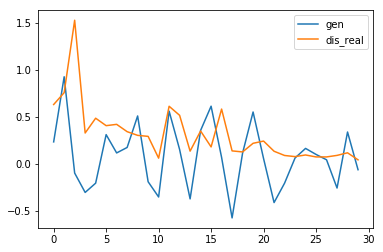

Generation 89  fitness : -47.958717869426394
#################################
Measured population fitness : 9s
population fitness : [-115.66274387  -49.28304391  -47.8840869   -68.95224742  -91.9516608
  -38.46212484  -96.04626697  -99.64879942  -81.0645424   -67.67888566]
mean fit : -75.66344021889132
Trained GAN : 1s
Evolved : 0s


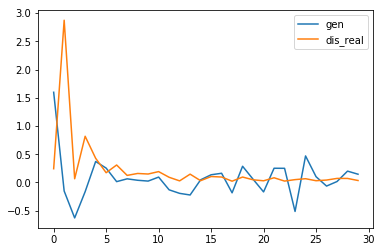

Generation 90  fitness : -38.46212484121371
#################################
Measured population fitness : 9s
population fitness : [-101.35381702  -78.64762121 -183.38491141  -99.14292005  -63.30785651
 -104.22832645  -55.01495289  -66.9265309   -39.8612296  -104.72308184]
mean fit : -89.65912478775536
Trained GAN : 1s
0.0809463945356648
Evolved : 0s


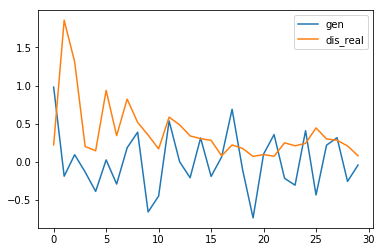

Generation 91  fitness : -39.86122960285626
#################################
Measured population fitness : 9s
population fitness : [ -87.04300348  -53.15599659 -124.41551478 -108.9967636   -99.81812236
  -88.51217445 -110.04703865  -91.2289757   -69.74075427 -100.08705575]
mean fit : -93.3045399624256
Trained GAN : 1s
Evolved : 0s


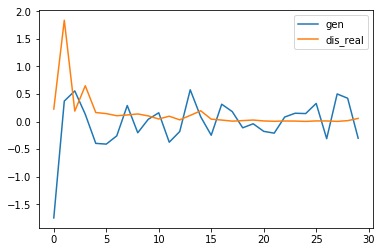

Generation 92  fitness : -53.15599658639564
#################################
Measured population fitness : 10s
population fitness : [-129.667892    -83.68772453 -131.28084108 -102.84781875  -38.99708143
  -93.69453081 -106.65843746 -122.42258869 -130.45205653 -110.10593352]
mean fit : -104.9814904804798
Trained GAN : 1s
Evolved : 0s


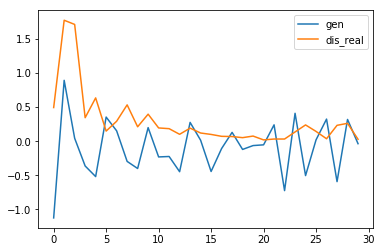

Generation 93  fitness : -38.99708142736921
#################################
Measured population fitness : 10s
population fitness : [-131.45549265 -141.69396472 -124.33696048 -105.05704941  -82.16963814
 -101.11849947 -129.17421218  -40.05774962  -96.72055655 -134.04462324]
mean fit : -108.5828746450502
Trained GAN : 1s
Evolved : 0s


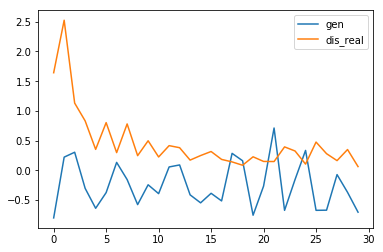

Generation 94  fitness : -40.05774961685784
#################################
Measured population fitness : 8s
population fitness : [-124.10799748  -75.73845207 -107.02898847  -49.85791587 -113.88243143
 -121.74297366  -91.08438646 -115.65849074  -82.13224424 -150.00410872]
mean fit : -103.12379891234464
Trained GAN : 1s
Evolved : 0s


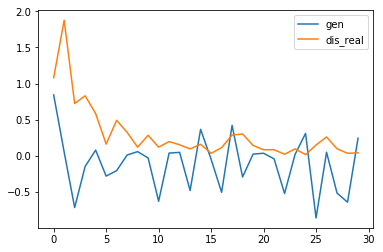

Generation 95  fitness : -49.857915867196986
#################################
Measured population fitness : 8s
population fitness : [-162.77477821  -59.92351751 -182.32354899 -107.96920589  -13.69821257
 -133.30931898  -47.57495246 -120.42266545  -98.77742074 -117.39144492]
mean fit : -104.4165065730045
Trained GAN : 1s
Evolved : 0s


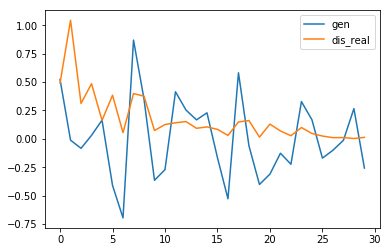

Generation 96  fitness : -13.698212567977626
#################################
Measured population fitness : 8s
population fitness : [-123.08411086  -39.76241253 -101.72640902  -75.09017279  -38.40272222
 -151.67170557  -77.17021576  -40.48291435  -71.50973626 -100.78643871]
mean fit : -81.96868380675187
Trained GAN : 1s
Evolved : 0s


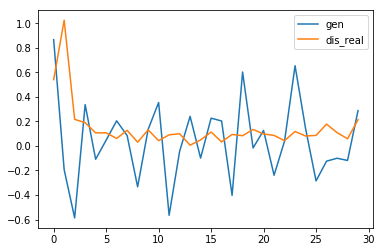

Generation 97  fitness : -38.40272222205356
#################################
Measured population fitness : 8s
population fitness : [-101.85403251  -17.67991215 -105.33747578 -119.03302964  -51.83147278
  -50.41845429  -24.54605434  -96.96435454 -100.70209718 -121.83492285]
mean fit : -79.02018060613547
Trained GAN : 1s
Evolved : 0s


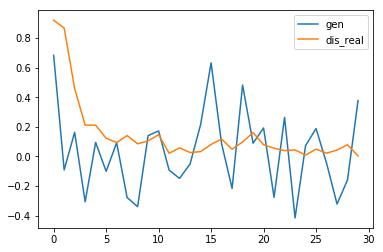

Generation 98  fitness : -17.679912151482885
#################################
Measured population fitness : 7s
population fitness : [ -99.61865704  -48.42083862 -109.68403895 -105.05799528 -106.85556978
  -51.46875415 -100.15945947 -113.04101678  -69.13382221  -26.42172389]
mean fit : -82.98618761773668
Trained GAN : 1s
Evolved : 0s


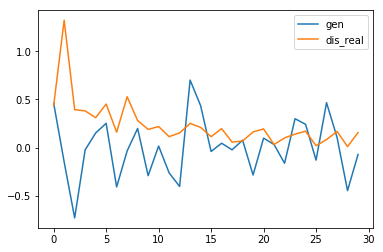

Generation 99  fitness : -26.421723894724636
#################################
Measured population fitness : 9s
population fitness : [-115.26042438  -65.88491689  -34.31032469  -51.68884615 -125.24812876
  -51.54183151 -105.04366012  -92.69261539  -29.35884111  -75.72737732]
mean fit : -74.67569663342015
Trained GAN : 1s
Evolved : 0s


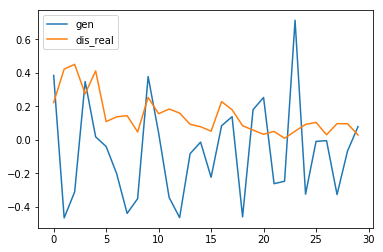

Generation 100  fitness : -29.358841113924555
#################################
Measured population fitness : 10s
population fitness : [ -83.85558256 -104.15441596  -38.99926668  -39.13052247  -40.5371051
 -107.60058154  -54.33052886 -122.91028025  -50.98584218  -65.31960239]
mean fit : -70.7823727979946
Trained GAN : 1s
0.0732064682546459
Evolved : 0s


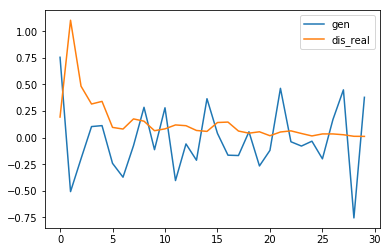

Generation 101  fitness : -38.999266683184146
#################################
Measured population fitness : 9s
population fitness : [ -44.59874682  -86.52166941 -103.85244196  -52.1778586   -70.64412986
 -115.42086849 -133.4589286   -50.86890286 -106.30567982  -56.91379086]
mean fit : -82.07630172936322
Trained GAN : 1s
Evolved : 0s


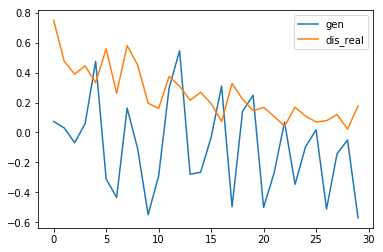

Generation 102  fitness : -44.59874682387975
#################################
Measured population fitness : 9s
population fitness : [ -53.33679585  -65.63231346 -110.35502404 -114.03986458 -116.45978458
  -61.1367101  -111.51245492  -58.75886422  -46.5829871   -40.94680893]
mean fit : -77.87616077798423
Trained GAN : 1s
Evolved : 0s


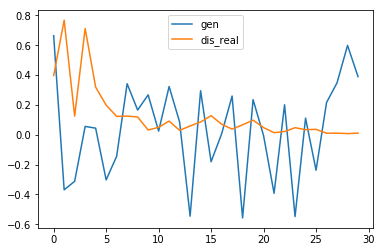

Generation 103  fitness : -40.94680893451347
#################################
Measured population fitness : 9s
population fitness : [ -41.1602192   -68.08925873  -66.47509412 -107.26464086 -156.30597467
  -78.23599236  -43.10329304  -90.63716428  -59.30744731  -42.21674517]
mean fit : -75.27958297658789
Trained GAN : 1s
Evolved : 0s


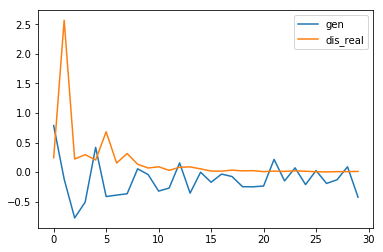

Generation 104  fitness : -41.16021920405629
#################################
Measured population fitness : 10s
population fitness : [ -86.63287295  -40.39574148  -44.42688616  -47.907166    -60.13136516
  -55.56725757  -28.51567574  -62.24194851  -84.3310181  -101.88782381]
mean fit : -61.203775547816555
Trained GAN : 1s
Evolved : 0s


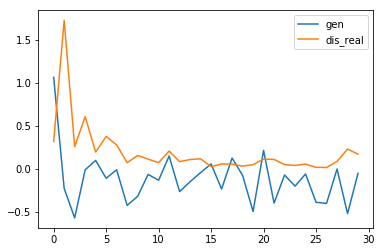

Generation 105  fitness : -28.51567573699676
#################################
Measured population fitness : 8s
population fitness : [ -31.02566764  -99.74418231  -32.68158352  -34.30216953  -86.39302171
  -91.67594781  -59.31087001 -122.13858031  -70.22196638  -45.9615038 ]
mean fit : -67.34554930400664
Trained GAN : 1s
Evolved : 0s


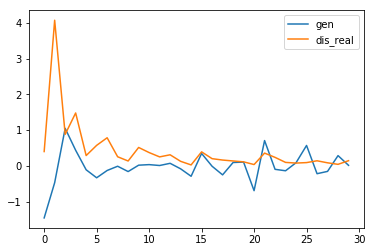

Generation 106  fitness : -31.02566764325075
#################################
Measured population fitness : 8s
population fitness : [ -65.47796382  -79.70989318  -74.11839764 -112.93586143  -52.06658512
  -53.15051225 -110.49113722  -32.51899483  -87.98269428 -104.55405241]
mean fit : -77.30060921845454
Trained GAN : 1s
Evolved : 0s


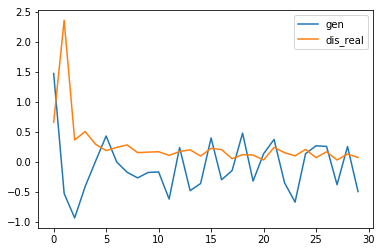

Generation 107  fitness : -32.51899483172889
#################################
Measured population fitness : 8s
population fitness : [-107.29370875  -57.405173    -62.76010114  -60.18713609  -33.06184843
  -47.55789392  -37.56782539  -98.93109743  -41.97293838 -112.89894075]
mean fit : -65.96366632848157
Trained GAN : 1s
Evolved : 0s


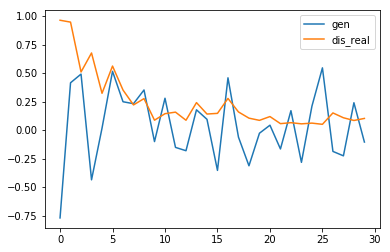

Generation 108  fitness : -33.061848425613086
#################################
Measured population fitness : 9s
population fitness : [ -26.97460055  -22.86939062  -65.14414962  -24.80085424  -34.28301918
  -37.01592906  -20.59518395  -91.75333936  -35.73367605 -116.92713849]
mean fit : -47.609728112465326
Trained GAN : 1s
Evolved : 0s


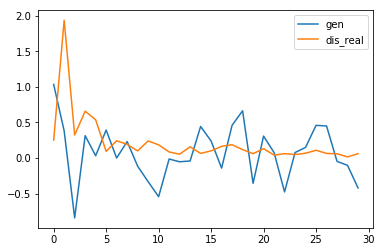

Generation 109  fitness : -20.595183947480596
#################################
Measured population fitness : 9s
population fitness : [-91.86387095 -75.17165217 -52.82945678 -48.67814857 -46.93403368
 -58.37989772 -74.29295501 -97.44365379 -52.4158677  -56.38798075]
mean fit : -65.43975171251721
Trained GAN : 1s
Evolved : 0s


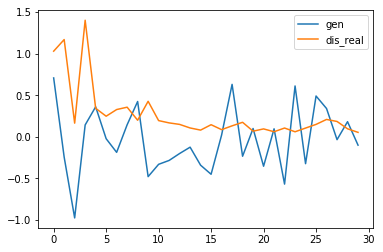

Generation 110  fitness : -46.93403368177084
#################################
Measured population fitness : 10s
population fitness : [-113.70627261  -35.74200533  -57.4344679   -94.03094316  -45.29007745
  -43.69368976  -46.19562687  -79.33250071  -70.06824999  -46.68140175]
mean fit : -63.217523552562206
Trained GAN : 1s
0.06620661766420284
Evolved : 0s


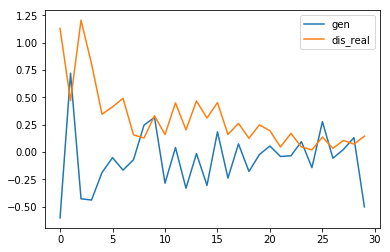

Generation 111  fitness : -35.74200533485477
#################################
Measured population fitness : 9s
population fitness : [ -49.68170717  -39.26561621  -60.46517913  -68.66780904  -90.50865568
  -94.23223705  -41.45825205  -46.17337368 -114.89338912  -50.23986793]
mean fit : -65.55860870423139
Trained GAN : 1s
Evolved : 0s


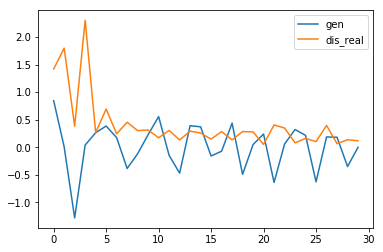

Generation 112  fitness : -39.265616209945215
#################################
Measured population fitness : 8s
population fitness : [-165.05010906 -123.77908366  -47.32039534  -77.84196528  -74.60538554
  -63.61830699  -77.45360066  -42.78100958 -103.80628372  -31.3411768 ]
mean fit : -80.75973166279286
Trained GAN : 0s
Evolved : 0s


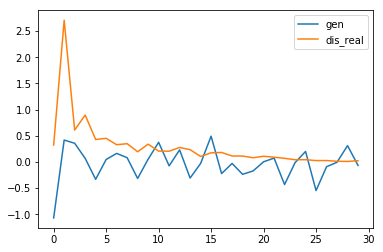

Generation 113  fitness : -31.341176797696214
#################################
Measured population fitness : 9s
population fitness : [ -73.24750227  -34.80771557 -100.89077424 -102.79083756  -30.83728185
 -108.19060323 -110.97526374  -44.95473043  -96.9493064   -53.18635143]
mean fit : -75.68303667195289
Trained GAN : 1s
Evolved : 0s


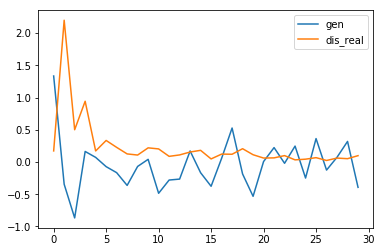

Generation 114  fitness : -30.83728185259691
#################################
Measured population fitness : 9s
population fitness : [-106.73715278  -76.73594414  -57.17156797 -112.64856902  -23.83212411
  -75.80966773 -114.4565586   -81.37307308  -34.51319373  -36.05917705]
mean fit : -71.93370282125515
Trained GAN : 1s
Evolved : 0s


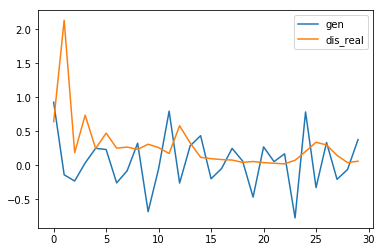

Generation 115  fitness : -23.832124114199736
#################################
Measured population fitness : 9s
population fitness : [ -69.48440722  -71.76062794 -112.92682268 -101.93396861  -98.39337231
  -46.12685253  -89.89835209  -50.28721667 -124.69323223  -84.39685447]
mean fit : -84.99017067496564
Trained GAN : 1s
Evolved : 0s


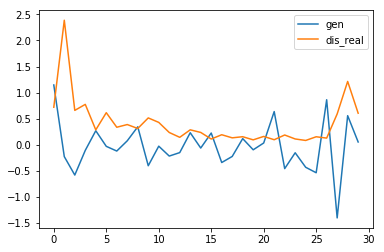

Generation 116  fitness : -46.126852531512476
#################################
Measured population fitness : 9s
population fitness : [ -78.2305371  -115.98212733 -115.91652366  -88.37338607  -84.02148793
  -48.18232222 -116.8925136  -134.12470772  -45.67103099  -57.71067724]
mean fit : -88.51053138763841
Trained GAN : 1s
Evolved : 0s


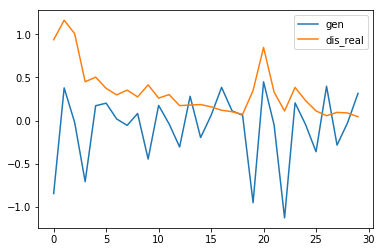

Generation 117  fitness : -45.67103098714706
#################################
Measured population fitness : 10s
population fitness : [-67.92202566 -94.91017834 -39.23523185 -86.13482324 -61.79413935
 -54.03998611 -69.57554686 -89.03634131 -37.63546841 -51.63807886]
mean fit : -65.19218199956883
Trained GAN : 1s
Evolved : 0s


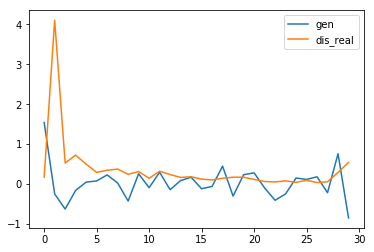

Generation 118  fitness : -37.635468414006354
#################################
Measured population fitness : 10s
population fitness : [-74.96612229 -56.94336939 -62.30854071 -85.50175709 -78.98861191
 -83.21778132 -56.43783566 -60.72681563 -70.11711825 -70.08255731]
mean fit : -69.92905095630897
Trained GAN : 1s
Evolved : 0s


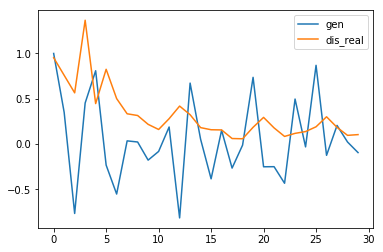

Generation 119  fitness : -56.437835662467414
#################################
Measured population fitness : 9s
population fitness : [-27.2977296  -87.46084592 -58.15464452 -83.68772049 -45.32210293
 -70.48127889 -80.57294835 -54.46172485 -94.09895318 -77.00387596]
mean fit : -67.85418246963064
Trained GAN : 1s
Evolved : 0s


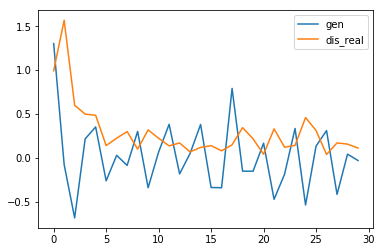

Generation 120  fitness : -27.29772960026839
#################################
Measured population fitness : 10s
population fitness : [-46.4155022  -64.00663232 -24.89484937 -68.323003   -50.83077593
 -53.89700375 -38.62301609 -48.27865233 -85.76427818 -94.08935097]
mean fit : -57.51230641425489
Trained GAN : 1s
0.05987607826246635
Evolved : 0s


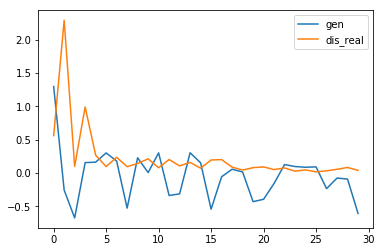

Generation 121  fitness : -24.89484937076145
#################################
Measured population fitness : 8s
population fitness : [-103.51670477  -25.56138398 -101.8867463  -103.95503193  -93.39136634
  -71.38030283  -35.05482821  -53.91941765  -94.30917548 -113.29376092]
mean fit : -79.6268718430797
Trained GAN : 1s
Evolved : 0s


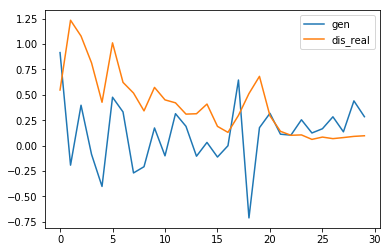

Generation 122  fitness : -25.561383984502545
#################################
Measured population fitness : 9s
population fitness : [-107.49823296  -29.62858653  -47.94086635  -18.84664059 -103.42831814
  -90.23612757 -130.21763753  -89.33718292  -69.00204451  -39.280024  ]
mean fit : -72.54156611026175
Trained GAN : 1s
Evolved : 0s


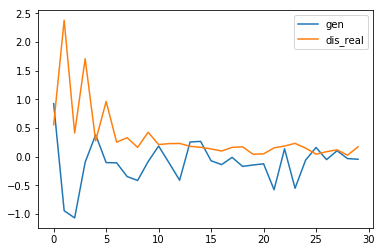

Generation 123  fitness : -18.84664058787933
#################################
Measured population fitness : 8s
population fitness : [ -38.55495728 -107.49855466  -21.37132293  -70.04327662  -94.89406483
  -99.2046049   -76.42170427  -64.81553678 -133.23138619  -91.66829394]
mean fit : -79.77037023991052
Trained GAN : 1s
Evolved : 0s


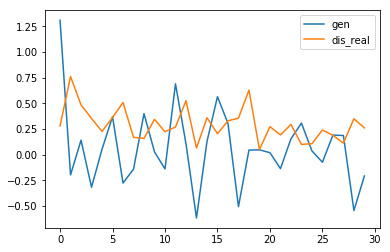

Generation 124  fitness : -21.371322930537115
#################################
Measured population fitness : 7s
population fitness : [ -81.86080423 -104.0781004   -46.87183075  -79.92597227  -17.40570573
  -98.67678003 -119.91460186  -56.65558735  -98.81922741 -105.96113642]
mean fit : -81.01697464490572
Trained GAN : 1s
Evolved : 0s


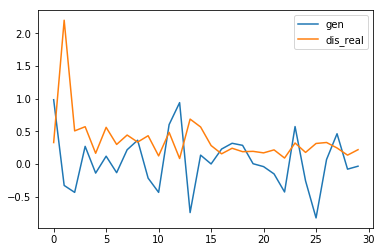

Generation 125  fitness : -17.405705732640527
#################################
Measured population fitness : 11s
population fitness : [-128.30028038  -81.02440309  -41.3353043  -139.78879631  -90.23400718
  -80.76604379  -60.18699502  -67.10850945  -96.3895793  -114.16279316]
mean fit : -89.92967119816149
Trained GAN : 1s
Evolved : 0s


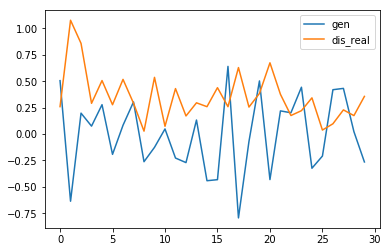

Generation 126  fitness : -41.33530429554588
#################################
Measured population fitness : 8s
population fitness : [-104.68568086  -61.04442349 -102.38980011  -54.82885188  -26.92300599
  -84.97387113  -84.085367   -106.86563303 -101.96028747 -112.84169959]
mean fit : -84.05986205521879
Trained GAN : 1s
Evolved : 0s


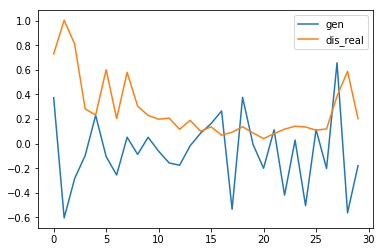

Generation 127  fitness : -26.923005988268898
#################################
Measured population fitness : 8s
population fitness : [ -91.17371275 -110.63049605  -90.32001478 -102.62430937  -99.70283558
  -96.5575051   -45.08611919  -65.63223402  -84.15261076  -56.69999368]
mean fit : -84.25798312939284
Trained GAN : 1s
Evolved : 0s


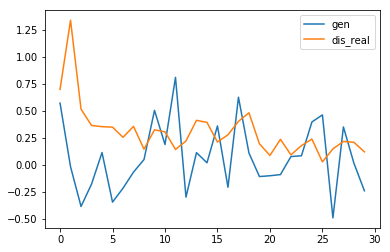

Generation 128  fitness : -45.08611919368337
#################################
Measured population fitness : 9s
population fitness : [ -81.74545565 -100.78261782  -83.40615577  -82.35510798  -83.19468318
  -45.0861851   -45.13304133 -106.19783684  -90.64429827  -58.81972291]
mean fit : -77.73651048594553
Trained GAN : 1s
Evolved : 0s


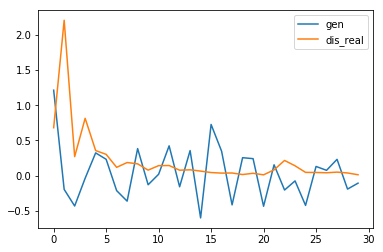

Generation 129  fitness : -45.08618510477879
#################################
Measured population fitness : 9s
population fitness : [ -69.26659562  -82.5393436   -85.85781231  -60.19094342  -32.42002201
  -55.81028244  -94.7504175  -101.00783191  -73.48613421  -25.93968394]
mean fit : -68.1269066969844
Trained GAN : 1s
Evolved : 0s


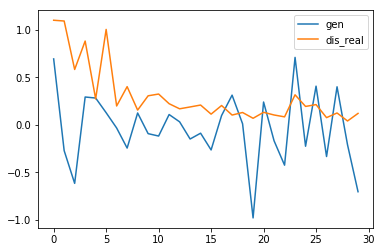

Generation 130  fitness : -25.93968394196588
#################################
Measured population fitness : 9s
population fitness : [-48.94872331 -82.35668699 -80.94620555 -97.0167499  -49.19480463
 -40.66146638 -79.50642459 -74.34197499 -57.20167622 -92.57112609]
mean fit : -70.27458386525271
Trained GAN : 1s
0.05415085190239889
Evolved : 0s


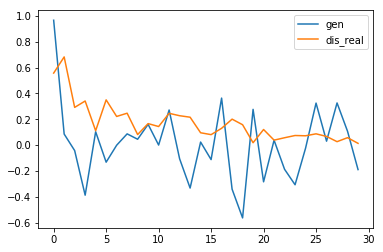

Generation 131  fitness : -40.66146637788095
#################################


In [ ]:
population_size = 10
max_population = population_size
max_population_batch = 2
batch_size = population_size
out_size = population_size
n_generations = 300000

#randomly inititialise starting population
population = []
for p in range(population_size):
    population.append(Creature(env.observation_space.shape[0],creature_out_size).to(device))

gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
mutation_scale = 0.2
for i in range(n_generations):
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002,betas=(0.5,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001,betas=(0.5,0.999))
   
    start_time = time.time()
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch = ((fitness_batch - np.mean(fitness_batch))/np.sqrt(np.var(fitness_batch)+epsilon))
    
    #Train GAN
    start_time = time.time()
    gen_loss, dis_loss = train_gan(population_batch,fitness_batch,
              batch_size =min(batch_size,len(population_batch)//2),n_epochs = 15)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
        print(mutation_scale)
    
    #Scale of normal distribution used for mutation
    mutation_scale *= 0.99
    mutation_rate = 1
    mutation_rate = np.random.choice([0.1, 0], p_fitness_.shape,p=[mutation_rate,1-mutation_rate])
    mutation_rate[np.argsort(p_fitness_)[(p_fitness_.size-len(population)//3):]] = 0
    
    #progressively grow population at start
    if out_size < max_population:
        out_size+=2
    
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mutation_rate,mutation_scale)
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis_real')
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
env = gym.make(envs[-2]).unwrapped

p_fitness = measure_population_fitness(population,env,device,discrete_actions,min_reward=-100,
                                                             max_steps = 200)

fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,min_reward=-100,
                                  render = True,max_steps = 5000000)
print(fitness)